In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import numpy as np
import pickle
import json
import pandas as pd
from datetime import datetime
import warnings
from matplotlib import pyplot as plt
import seaborn as sns
from nilearn.plotting import plot_design_matrix
from nilearn.image import load_img
from nilearn.reporting import make_glm_report
from nilearn import image
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix
from nilearn.plotting import plot_design_matrix
sys.path.append('..')
from utils.data import Subject, load_participant_list, create_dummy_regressors
from utils.analysis import compute_parametric_modulator

In [3]:
base_dir = '/home/ubuntu/data/learning-habits'
bids_dir = "/home/ubuntu/data/learning-habits/bids_dataset/derivatives/fmriprep-24.0.1"

In [4]:
subject = Subject(base_dir, '02', include_modeling=True, include_imaging=True, bids_dir=bids_dir)

In [47]:
model_params = {
    'model_name': 'collapsed',
    'tr': 2.33384,
    'hrf_model': 'spm',
    'noise_model': 'ar1',
    'smoothing_fwhm': 5,
    'high_pass': 0.01,
    'motion_type': 'basic',
    'fd_thresh': 0.5,
    'std_dvars_thresh': 2,
    'scrub': 'dummies',
    'modulators': 'both',
    'exclude_stimuli': True,
    'include_physio': True,
    'brain_mask': True,
    'duration': 'all',
    'modulator_normalization': 'zscore',
    'exclusion_threshold': 0.2
}

run = 'learning1'

In [27]:
# Parameters
model_name = model_params["model_name"]
tr = model_params["tr"]
hrf_model = model_params["hrf_model"]
noise_model = model_params["noise_model"]
smoothing_fwhm = model_params["smoothing_fwhm"]
high_pass = model_params["high_pass"]
include_physio = model_params["include_physio"]
brain_mask = model_params["brain_mask"]
modulator_normalization = model_params["modulator_normalization"]
modulators = model_params["modulators"]
exclude_stimuli = model_params["exclude_stimuli"]
motion_type = model_params["motion_type"]
fd_thresh = model_params["fd_thresh"]
std_dvars_thresh = model_params["std_dvars_thresh"]
scrub = model_params["scrub"]

In [28]:
# Load confounds
confounds, sample_mask = subject.load_confounds(run, motion_type=motion_type,
                                                fd_thresh=fd_thresh, std_dvars_thresh=std_dvars_thresh,
                                                scrub=(0 if scrub == 'dummies' else scrub))
if include_physio:
    physio_regressors = subject.load_physio_regressors(run)
    confounds = confounds.join(physio_regressors)

In [29]:
if scrub == 'dummies':
    dummies = create_dummy_regressors(sample_mask, len(confounds))
    confounds = pd.concat([confounds, dummies], axis=1)

In [30]:
# Load fMRI volume
img_path = subject.img.get(run)
fmri_img = load_img(img_path)

In [31]:
if brain_mask:
    brain_mask_path = subject.brain_mask.get(run)
    brain_mask = load_img(brain_mask_path)
else:
    brain_mask = None

n = fmri_img.shape[-1]
frametimes = np.linspace(tr / 2., (n - .5) * tr, n)

In [32]:
if modulators == 'both':
    columns_event = {'first_stim_value_rl':'first_stim_presentation',
                    'first_stim_value_ck':'first_stim_presentation',
                    'first_stim':'first_stim_presentation'}
    # Load events
    events = getattr(subject, run).extend_events_df(columns_event)
elif modulators == 'none':
    events = getattr(subject, run).events
else:
    raise NotImplementedError("Modulator type not implemented")

# Collapsing events

In [33]:
def collapse_events(df):
    """
    Collapse events within each 'trial' in the given DataFrame according to:
      - sum durations of first_stim_presentation + second_stim_presentation → 'stim_presentation'
      - if a response exists: sum durations of response + purple_frame + points_feedback → 'feedback'
      - otherwise keep 'non_response_feedback'
      - keep 'iti' as it is

    Copies all columns from the reference row except 'trial', 'trial_type', 'onset', and 'duration',
    and reorders final columns to match the original df.
    """
    EXCLUDE_COLS = ['trial', 'trial_type', 'onset', 'duration']

    # Save the original column order for later use
    original_cols = df.columns

    def build_collapsed_row(ref_row, new_trial, new_type, new_onset, new_duration):
        """
        Given a reference row (e.g., from first_stim), create a dict:
          - Copies all columns from ref_row except the ones in EXCLUDE_COLS
          - Overwrites trial, trial_type, onset, duration
        """
        meta = ref_row.drop(labels=EXCLUDE_COLS).to_dict()
        meta.update({
            'trial':      new_trial,
            'trial_type': new_type,
            'onset':      new_onset,
            'duration':   new_duration,
        })
        return meta

    collapsed_data = []

    # Group by trial
    for trial_id, grp in df.groupby('trial', sort=False):
        # 1) Combine first and second stim
        first_stim  = grp.query("trial_type == 'first_stim_presentation'").iloc[0]
        second_stim = grp.query("trial_type == 'second_stim_presentation'").iloc[0]

        stim_row = build_collapsed_row(
            ref_row      = first_stim,
            new_trial    = trial_id,
            new_type     = 'stim_presentation',
            new_onset    = first_stim['onset'],
            new_duration = first_stim['duration'] + second_stim['duration']
        )
        collapsed_data.append(stim_row)

        # 2) Combine feedback events if a response exists, else keep non_response_feedback
        response_rows = grp.query("trial_type in ['response', 'purple_frame', 'points_feedback']")

        if not response_rows.empty:
            # Sum durations
            earliest_onset = response_rows['onset'].min()
            total_duration = response_rows['duration'].sum()
            feedback_row = build_collapsed_row(
                ref_row      = first_stim,
                new_trial    = trial_id,
                new_type     = 'feedback',
                new_onset    = earliest_onset,
                new_duration = total_duration
            )
            collapsed_data.append(feedback_row)
        else:
            non_resp = grp.query("trial_type == 'non_response_feedback'").iloc[0]
            feedback_row = build_collapsed_row(
                ref_row      = non_resp,
                new_trial    = trial_id,
                new_type     = 'non_response_feedback',
                new_onset    = non_resp['onset'],
                new_duration = non_resp['duration']
            )
            collapsed_data.append(feedback_row)

        # 3) Keep ITI as is
        iti = grp.query("trial_type == 'iti'").iloc[0]
        iti_row = build_collapsed_row(
            ref_row      = iti,
            new_trial    = trial_id,
            new_type     = 'iti',
            new_onset    = iti['onset'],
            new_duration = iti['duration']
        )
        collapsed_data.append(iti_row)

    # Build the collapsed DataFrame
    collapsed_df = pd.DataFrame(collapsed_data)

    # Reorder columns to match the original DataFrame's order (only for columns that exist in collapsed_df)
    final_cols = [c for c in original_cols if c in collapsed_df.columns]
    # If you also want any new columns (unlikely in this scenario) to appear after the original ones:
    extra_cols = [c for c in collapsed_df.columns if c not in original_cols]
    collapsed_df = collapsed_df[final_cols + extra_cols]

    return collapsed_df

In [34]:
events.head(20)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck,first_stim
0,0.005624,0.817359,first_stim_presentation,1,2.332217,0.000000,7.0
1,0.822983,0.615436,second_stim_presentation,1,0.000000,0.000000,0.0
2,1.438419,0.000000,response,1,0.000000,0.000000,0.0
3,1.456892,1.918454,purple_frame,1,0.000000,0.000000,0.0
4,1.974071,1.401274,points_feedback,1,0.000000,0.000000,0.0
5,3.375345,7.957434,iti,1,0.000000,0.000000,0.0
6,11.332779,0.834021,first_stim_presentation,2,4.000000,0.003004,7.0
7,12.166800,0.478543,second_stim_presentation,2,0.000000,0.000000,0.0
8,12.645344,0.000000,response,2,0.000000,0.000000,0.0
9,12.650588,2.051938,purple_frame,2,0.000000,0.000000,0.0


In [35]:
collapsed = collapse_events(events)

In [38]:
collapsed.head(40)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck,first_stim
0,0.005624,1.432795,stim_presentation,1,2.332217,0.000000,7.0
1,1.438419,3.319728,feedback,1,2.332217,0.000000,7.0
2,3.375345,7.957434,iti,1,0.000000,0.000000,0.0
3,11.332779,1.312565,stim_presentation,2,4.000000,0.003004,7.0
4,12.645344,3.586739,feedback,2,4.000000,0.003004,7.0
5,14.702526,6.038987,iti,2,0.000000,0.000000,0.0
6,20.741513,1.414852,stim_presentation,3,4.000000,0.005999,7.0
7,22.156366,3.686760,feedback,3,4.000000,0.005999,7.0
8,24.261346,7.206754,iti,3,0.000000,0.000000,0.0
9,31.468100,1.268341,stim_presentation,4,2.094122,0.000000,1.0


In [16]:
if exclude_stimuli:
    collapsed['trial_type'] = collapsed.apply(
        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
        if row['trial_type'] == 'stim_presentation' else row['trial_type'],
        axis=1
    ) 

if exclude_stimuli:
    events['trial_type'] = events.apply(
        lambda row: f"{row['trial_type']}_{'exclude' if int(row['first_stim']) in (1, 8) else 'include'}"
        if row['trial_type'] == 'first_stim_presentation' else row['trial_type'],
        axis=1
    ) 

In [17]:
collapsed.head(20)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck,first_stim
0,0.009226,1.182227,stim_presentation_exclude,1,5.0,0.126393,8.0
1,1.191453,2.151995,feedback,1,5.0,0.126393,8.0
2,3.362241,7.240122,iti,1,0.0,0.000000,0.0
3,10.602363,1.264057,stim_presentation_include,2,4.0,0.038897,6.0
4,11.866420,2.185362,feedback,2,4.0,0.038897,6.0
5,14.055476,6.222508,iti,2,0.0,0.000000,0.0
6,20.277984,1.203520,stim_presentation_include,3,4.0,0.038780,6.0
7,21.481504,2.118644,feedback,3,4.0,0.038780,6.0
8,23.614338,6.522792,iti,3,0.0,0.000000,0.0
9,30.137131,1.244324,stim_presentation_include,4,4.0,0.095413,7.0


In [18]:
events.head(20)

,onset,duration,trial_type,trial,first_stim_value_rl,first_stim_value_ck,first_stim
0,0.009226,0.817357,first_stim_presentation_exclude,1,5.0,0.126393,8.0
1,0.826583,0.364869,second_stim_presentation,1,0.0,0.000000,0.0
2,1.191453,0.000000,response,1,0.0,0.000000,0.0
3,1.210246,2.151995,purple_frame,1,0.0,0.000000,0.0
4,3.362241,7.240122,iti,1,0.0,0.000000,0.0
5,10.602363,0.934128,first_stim_presentation_include,2,4.0,0.038897,6.0
6,11.536491,0.329929,second_stim_presentation,2,0.0,0.000000,0.0
7,11.866420,0.000000,response,2,0.0,0.000000,0.0
8,11.870114,2.185362,purple_frame,2,0.0,0.000000,0.0
9,14.055476,6.222508,iti,2,0.0,0.000000,0.0


In [19]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix = make_first_level_design_matrix(frame_times=frametimes,
                                    events=events,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

In [20]:
# Ignore warnings related to null duration events and unexpected columns in events data
warnings.filterwarnings("ignore", message=".*events with null duration.*")
warnings.filterwarnings("ignore", message=".*following unexpected columns in events data.*")
# Create design matrix
design_matrix_collapsed = make_first_level_design_matrix(frame_times=frametimes,
                                    events=collapsed,
                                    hrf_model=hrf_model,
                                    drift_model=None,
                                    high_pass=high_pass,
                                    add_regs=confounds)

/tmp/ipykernel_357852/2810574807.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(design_matrix_collapsed[:100][cols2plot])


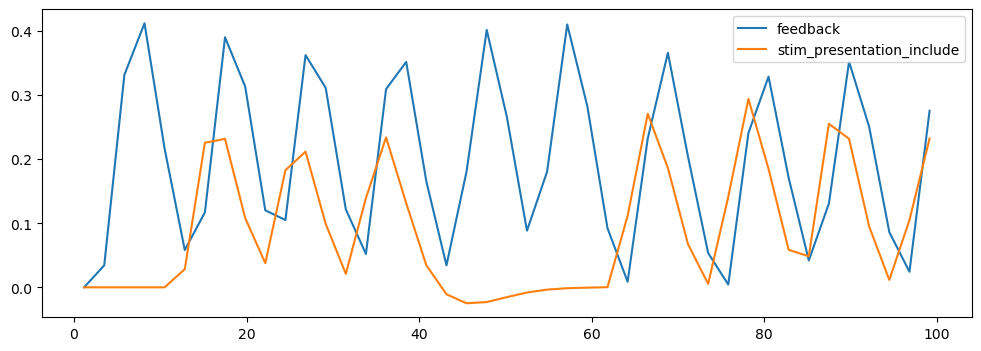

In [21]:
cols2plot = ['feedback', 'stim_presentation_include']
plt.figure(figsize=(12, 4))
plt.plot(design_matrix_collapsed[:100][cols2plot])
plt.legend(cols2plot)

/tmp/ipykernel_357852/1555711778.py:3: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  plt.plot(design_matrix[:100][cols2plot])


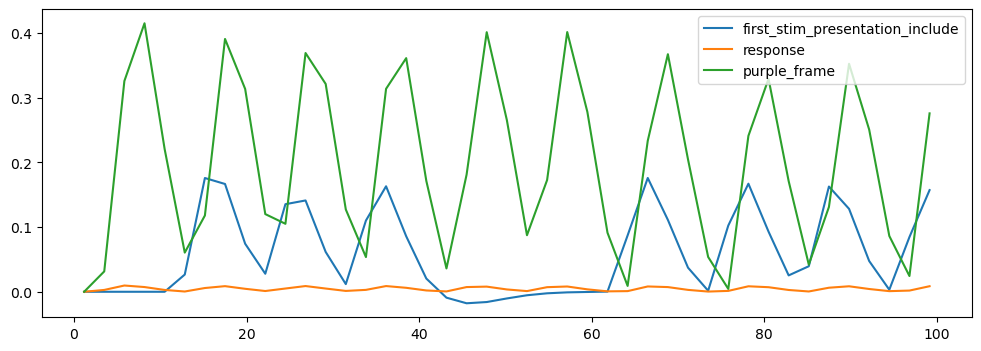

In [22]:
cols2plot = ['first_stim_presentation_include', 'response', 'purple_frame']
plt.figure(figsize=(12, 4))
plt.plot(design_matrix[:100][cols2plot])
plt.legend(cols2plot)

In [23]:
if modulators == 'both':
    # RL Parametric modulation
    parametric_modulator_column = 'first_stim_value_rl'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(1, parametric_modulator_column, reg_value)

    # CK Parametric modulation
    parametric_modulator_column = 'first_stim_value_ck'
    condition = 'first_stim_presentation_include' if exclude_stimuli else 'first_stim_presentation'
    reg_value = compute_parametric_modulator(events, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix.insert(2, parametric_modulator_column, reg_value)

In [24]:
if modulators == 'both':
    # RL Parametric modulation
    parametric_modulator_column = 'first_stim_value_rl'
    condition = 'stim_presentation_include' if exclude_stimuli else 'stim_presentation'
    reg_value = compute_parametric_modulator(collapsed, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix_collapsed.insert(1, parametric_modulator_column, reg_value)

    # CK Parametric modulation
    parametric_modulator_column = 'first_stim_value_ck'
    condition = 'stim_presentation_include' if exclude_stimuli else 'stim_presentation'
    reg_value = compute_parametric_modulator(collapsed, condition, parametric_modulator_column,
                                                frametimes, hrf_model, normalize=modulator_normalization)
    design_matrix_collapsed.insert(2, parametric_modulator_column, reg_value)

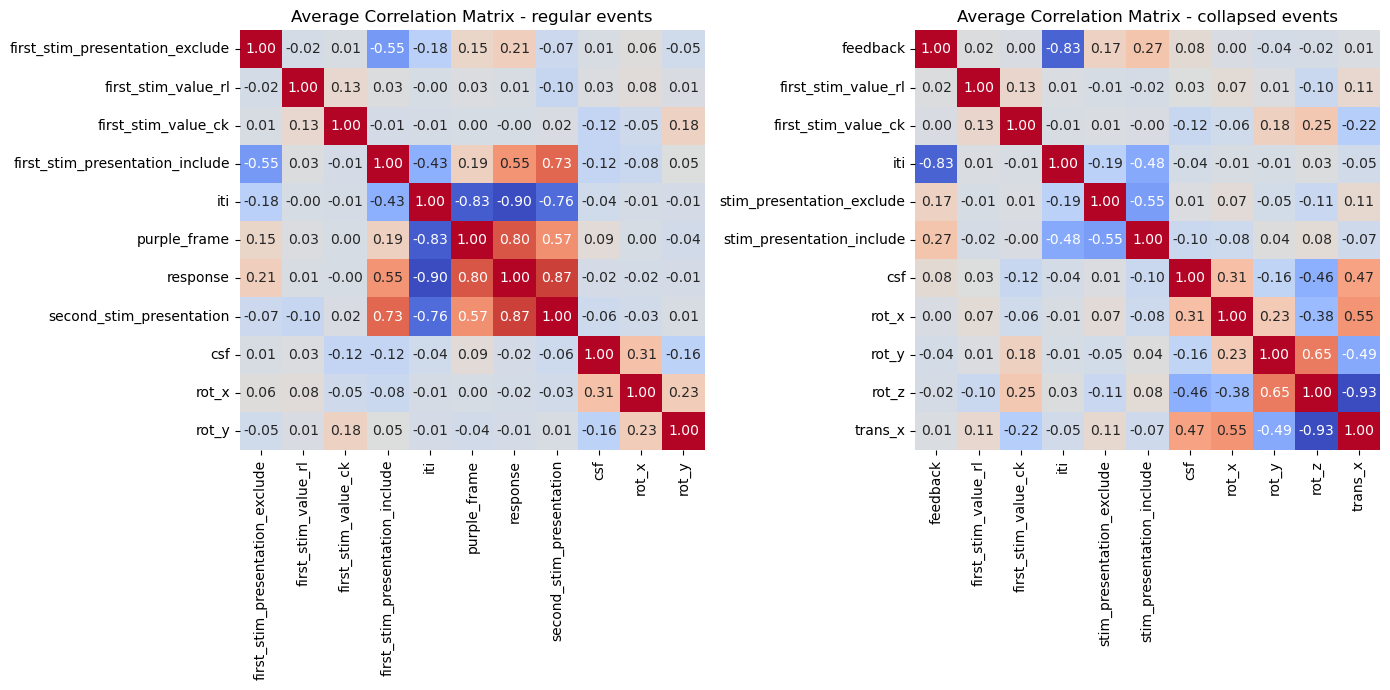

In [25]:
nc = 11
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

average_correlation_matrix = design_matrix.corr().values
sns.heatmap(average_correlation_matrix[:nc,:nc], xticklabels=design_matrix.columns[:nc], 
            yticklabels=design_matrix.columns[:nc], cmap='coolwarm', annot=True, fmt=".2f", ax=axes[0], cbar=False)
axes[0].set_title('Average Correlation Matrix - regular events')

average_correlation_matrix = design_matrix_collapsed.corr().values
sns.heatmap(average_correlation_matrix[:nc,:nc], xticklabels=design_matrix_collapsed.columns[:nc],
            yticklabels=design_matrix_collapsed.columns[:nc], cmap='coolwarm', annot=True, fmt=".2f", ax=axes[1], cbar=False)
axes[1].set_title('Average Correlation Matrix - collapsed events')

plt.tight_layout()
plt.show() 